In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#importing csv files
all_site = pd.read_csv(r'all_site.csv')
rul = pd.read_csv(r'RUL.csv')

In [3]:
all_site.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3341 entries, 0 to 3340
Data columns (total 10 columns):
index           3341 non-null int64
Site            3338 non-null object
Event Date      3341 non-null object
WUC             3038 non-null object
Failure         757 non-null float64
R&R             702 non-null float64
Action Taken    2480 non-null object
Rem Sn          689 non-null object
Ins Sn          818 non-null object
How Mal         3180 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 261.1+ KB


In [4]:
all_site.head()

,index,Site,Event Date,WUC,Failure,R&R,Action Taken,Rem Sn,Ins Sn,How Mal
0,3220,NaN,7/7/2017,JB200,0.0,0.0,X,,804,801.0
1,3239,NaN,8/16/2017,JB200,0.0,0.0,X,,627,801.0
2,3244,NaN,8/28/2017,JB200,0.0,0.0,X,,626,801.0
3,1700,1.00E+01,10/4/2010,03YR1,NaN,NaN,NaN,NaN,NaN,0.0
4,1869,1.00E+01,5/3/2011,JA200,NaN,NaN,X,NaN,NaN,799.0


In [5]:
rul.head()

,Years,Percent_RUL
0,0.000000,100.0000
1,0.215131,99.8178
2,0.531525,99.8197
3,0.732868,99.8209
4,0.819157,99.8215


In [6]:
#descriptive statistics summary
rul.describe()

,Years,Percent_RUL
count,167.000000,167.000000
mean,12.196671,49.658787
std,8.138375,36.272862
min,0.000000,0.363594
25%,5.380325,13.344650
50%,10.807500,49.882500
75%,17.845550,85.143450
max,29.568500,100.000000


## Plot of RUL Vs year

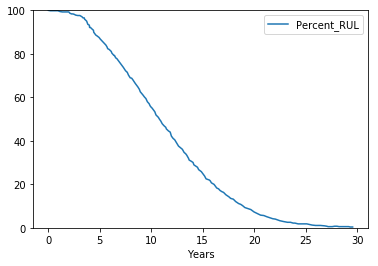

In [7]:
var = 'Years'
data = pd.concat([rul['Percent_RUL'], rul[var]], axis=1)
data.plot(x=var, y='Percent_RUL', ylim=(0,100))

## Distribution of RUL

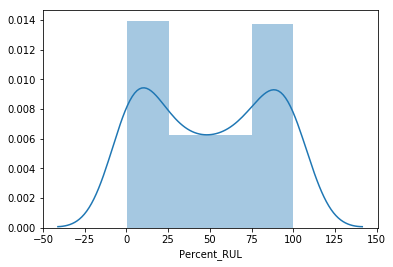

In [8]:
#histogram
sns.distplot(rul['Percent_RUL'])

## Missing Values

In [9]:
#missing values
total = all_site.isnull().sum().sort_values(ascending=False)
percent_1 = all_site.isnull().sum()/all_site.isnull().count()*100
percent_2 = (round(percent_1,1)).sort_values(ascending=False)
missing_data = pd.concat([total,percent_2], axis=1, keys=['Total', '%'])
missing_data.sort_values(ascending=False, by='%')

,Total,%
Rem Sn,2652,79.4
R&R,2639,79.0
Failure,2584,77.3
Ins Sn,2523,75.5
Action Taken,861,25.8
WUC,303,9.1
How Mal,161,4.8
Site,3,0.1
Event Date,0,0.0
index,0,0.0


In [10]:
#Replacing missing values in R&R
#replacing R&R as 1 for Action Taken =R
all_site.loc[(all_site['R&R'].isnull()) & (all_site['Action Taken'] == 'R'), 'R&R'] = 1.0
all_site.loc[(all_site['Action Taken'] == 'R'), 'R&R'] = 1.0
#replacing other null values with 0
all_site.loc[all_site['R&R'].isnull(),'R&R'] = 0.0

#Replacing missing values in Ins Sn - To deal with the missing values in Ins Sn creating a new column combining Site,WUC and Ins Sn
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
            [df[col] for col in cols])
all_site['WUC-Ins Sn'] = str_join(all_site, '-', 'Site','WUC', 'Ins Sn',)

#replacing missing values in Failure
all_site.loc[(all_site['R&R']==1.0) | (all_site['Action Taken'] == 'R'), 'Failure'] = 1.0
all_site.loc[(all_site['R&R']==1.0), 'Failure'] = 1.0
#replacing other null values with 0
all_site.loc[all_site['Failure'].isnull(),'Failure'] = 0.0

In [11]:
#missing values
total = all_site.isnull().sum().sort_values(ascending=False)
percent_1 = all_site.isnull().sum()/all_site.isnull().count()*100
percent_2 = (round(percent_1,1)).sort_values(ascending=False)
missing_data = pd.concat([total,percent_2], axis=1, keys=['Total', '%'])
missing_data.sort_values(ascending=False, by='%')

,Total,%
Rem Sn,2652,79.4
Ins Sn,2523,75.5
Action Taken,861,25.8
WUC,303,9.1
How Mal,161,4.8
Site,3,0.1
WUC-Ins Sn,0,0.0
R&R,0,0.0
Failure,0,0.0
Event Date,0,0.0


In [12]:
Good_parts = all_site.loc[(all_site['Failure']== 0.0) & (all_site['R&R'] == 0.0)] 
Failed_replaced_parts = all_site.loc[(all_site['Failure']== 1.0) & (all_site['R&R'] == 1.0)] 

## Calculating Used Time

In [13]:
from datetime import date
today = date.today()
all_site['Event Date'] = pd.to_datetime(all_site['Event Date'])
Y = today - all_site['Event Date']
Y = Y.dt.days/365.5
Y = Y.rename('Y')
Y[0:10]

0    1.222982
1    1.113543
2    1.080711
3    7.975376
4    7.398085
5    6.766074
6    5.668947
7    5.083447
8    5.083447
9    4.771546
Name: Y, dtype: float64

## Calculating RUC

In [14]:
RUL = -0.0007*Y**4 + 0.0505*Y**3 - 1.0342*Y**2 + 1.5831*Y + 99.715
RUL = RUL.rename('RUL')
RUL[0:10]

0    100.195074
1    100.264117
2    100.280780
3     69.344766
4     73.174466
5     77.256233
6     83.930746
7     87.203807
8     87.203807
9     88.845838
Name: RUL, dtype: float64

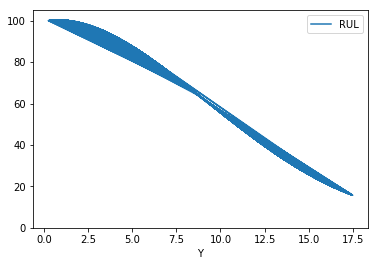

In [15]:
data = pd.concat((Y, RUL) , axis=1)
data.plot(x='Y', y='RUL', ylim=(0,105))

## Lasso Regression

In [16]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=4000

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 7

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(rul['Years'], rul['Percent_RUL'],test_size=0.33)

In [17]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [18]:
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)

In [19]:
test_score

0.9989612832856536

## Predict for test data

In [20]:
Y = Y.reshape(-1,1)
predicted_rul = model.predict(Y)

In [28]:
prediction = pd.DataFrame(all_site['Site'], columns= ['Site'])
prediction['WUC'] = all_site['WUC']
prediction['Ins Sn'] = all_site['Ins Sn']
prediction['Event Date'] = all_site['Event Date']
prediction['Used Life(in Years)'] = Y
prediction['predicted_rul'] = predicted_rul
predicted_rul = predicted_rul.reshape(-1,1)
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0, 100))
scaler = scaler.fit(predicted_rul)
X_scaled = scaler.transform(predicted_rul)
prediction['predicted_rul'] = X_scaled
prediction.head()

,Site,WUC,Ins Sn,Event Date,Used Life(in Years),predicted_rul
0,NaN,JB200,804,2017-07-07,1.222982,97.711919
1,NaN,JB200,627,2017-08-16,1.113543,98.012930
2,NaN,JB200,626,2017-08-28,1.080711,98.101056
3,1.00E+01,03YR1,NaN,2010-10-04,7.975376,62.159237
4,1.00E+01,JA200,NaN,2011-05-03,7.398085,66.146452


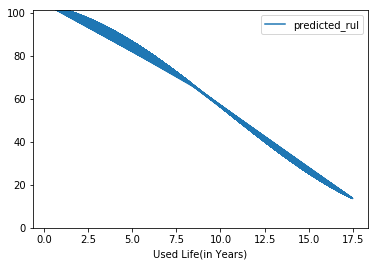

In [26]:
data = pd.concat([prediction['Used Life(in Years)'], prediction['predicted_rul']], axis=1)
data.plot(x='Used Life(in Years)', y='predicted_rul', ylim=(0,101))

In [27]:
prediction.head()

,Site,WUC,Ins Sn,Event Date,Used Life(in Years),predicted_rul
0,NaN,JB200,804,2017-07-07,1.222982,101.171880
1,NaN,JB200,627,2017-08-16,1.113543,101.441588
2,NaN,JB200,626,2017-08-28,1.080711,101.520550
3,1.00E+01,03YR1,NaN,2010-10-04,7.975376,69.316429
4,1.00E+01,JA200,NaN,2011-05-03,7.398085,72.889001
